In [1]:
import networkx as nx
import pandas as pd
import os
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import time
import random
from sklearn.metrics import f1_score
from collections import defaultdict 
from dgl.nn import SAGEConv
import scipy.sparse as sp
import json
import seaborn as sns
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
import dgl
from dgl.data.utils import save_graphs
from dgl import load_graphs

In [3]:
from dgl.nn import SAGEConv
import dgl.data

In [4]:
from collections import defaultdict

# Graph EDA

In [5]:
os.path.join(os.path.expanduser('~'), './test_save.bin')
glist, label_dict = load_graphs(os.path.join(os.path.expanduser('~'), './test_save.bin'))
g = glist[0]
degs = (g.in_degrees())
np.mean(np.array(degs))

312.876164831353

In [10]:
measures = pd.DataFrame(data=[170089, 26608397, 313, 13], index=['Nodes', 'Edges', 'Average Degree', 'Features'], columns=['Measure'])
measures

,Measure
Nodes,170089
Edges,26608397
Average Degree,313
Features,13


In [17]:
measures.to_csv('graph_measures.csv')

# Features EDA

In [18]:
numerical = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',]
categorical = ['key', 'mode', 'time_signature']

In [19]:
data_path = (os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/'))

In [20]:
def wowa(thelist):
    eligible = []
    for x in thelist:
        nums = pd.Series(x.strip('mpd.slice.json').split('-')).astype(int)
        if nums[0] <= 9999:
            eligible.append(x)
    return eligible

In [21]:
wowa(pd.Series(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/'))))

['mpd.slice.4000-4999.json',
 'mpd.slice.9000-9999.json',
 'mpd.slice.0-999.json',
 'mpd.slice.1000-1999.json',
 'mpd.slice.8000-8999.json',
 'mpd.slice.5000-5999.json',
 'mpd.slice.3000-3999.json',
 'mpd.slice.7000-7999.json',
 'mpd.slice.6000-6999.json',
 'mpd.slice.2000-2999.json']

In [22]:
what = np.random.choice(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/')), replace=True)
what

'mpd.slice.583000-583999.json'

In [23]:
%%time
# Saving sample of playlists
playlists = []
for i in range(200):
    file_samp = np.random.choice(wowa(pd.Series(os.listdir(os.path.join(os.path.expanduser('~'), '/teams/DSC180A_FA21_A00/a13group1/data/')))), replace=True)
    fname = os.path.join(data_path, file_samp)
    with open(fname) as f:
        data = json.load(f)
        item = np.random.choice(data['playlists'])
        playlists.append(item)

CPU times: user 1min 27s, sys: 10.8 s, total: 1min 37s
Wall time: 1min 38s


In [24]:
# with open("" + 'mpd.slice.{}-{}.json'.format(0, 999)) as f:
#         data = json.load(f)
#         playlists = data['playlists']

In [25]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder()

In [26]:
edafeats = pd.read_csv('~/teams/DSC180A_FA21_A00/a13group1/songset_features_170k')
edafeats = edafeats.drop(columns=['Unnamed: 0', 'type', 'track_href', 'analysis_url'])

edafeats['loudness'] = std_scaler.fit_transform(edafeats[['loudness']])
edafeats['tempo'] = std_scaler.fit_transform(edafeats[['tempo']])
edafeats['duration_ms'] = std_scaler.fit_transform(edafeats[['duration_ms']])

In [27]:
playlists[0]['tracks'][7]

{'pos': 7,
 'artist_name': 'Terence Ryan',
 'track_uri': 'spotify:track:6gpIFmincfPfAFGxql3TYs',
 'artist_uri': 'spotify:artist:5ScbRGpNz5Ghc7hQh1werH',
 'track_name': 'To Live and Die in New England',
 'album_uri': 'spotify:album:4WetDqdeEsX66o8H2mXmbr',
 'duration_ms': 194000,
 'album_name': 'To Live and Die in New England'}

In [28]:
%%time
feat_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_avgs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_difs = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}
feat_ranges = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

for item in playlists:
    #item = playlists[each]
    
    row_ids = []
    for i in item['tracks']:
        row = edafeats[edafeats['uri'] == i['track_uri']].index.item()
        row_ids.append(row)
        
    
    cur_feats = edafeats.iloc[row_ids]
    
    for i in numerical:
        var = np.var(cur_feats[i])
        feat_vars[i].append(var)
        
        avg = np.mean(cur_feats[i])
        feat_avgs[i].append(avg)
        
        difs = np.mean(np.abs(cur_feats[i].diff())[1:])
        feat_difs[i].append(difs)
        
        ranges = np.abs(np.max(cur_feats[i]) - np.min(cur_feats[i]))
        feat_ranges[i].append(ranges)
        
        
        
    for i in categorical:
        highest = max(cur_feats[i].value_counts() / cur_feats[i].count())
        feat_vars[i].append(highest)

CPU times: user 3min 21s, sys: 1.96 s, total: 3min 22s
Wall time: 3min 23s


In [29]:
feat_avgs.pop('key')
feat_avgs.pop('mode')
feat_avgs.pop('time_signature')

feat_difs.pop('key')
feat_difs.pop('mode')
feat_difs.pop('time_signature')

feat_ranges.pop('key')
feat_ranges.pop('mode')
feat_ranges.pop('time_signature')

[]

In [30]:
for i in list(feat_vars.keys()):
    print(i, np.mean(feat_vars[i]))

danceability 0.017650296251833338
energy 0.02860940773710179
loudness 0.38807019824727945
speechiness 0.006427162461258471
acousticness 0.04880436752836086
instrumentalness 0.020828364239985447
liveness 0.022328711410748898
valence 0.042345559826602736
tempo 0.863864856606236
duration_ms 0.48473452506857967
key 0.20382327766618583
mode 0.688028189623177
time_signature 0.9364263544487826


# Within Playlists EDA (From 200 Song Sample)

When plotting the distribution of variance for danceability of the 200 sampled playlists we can see that it follows a sort of bimodal distribution, where the variance is always quite low. This suggests that the songs within each playlist follow a sort of similarity in danceability. As we plot the variances of the other playlists we can get different values.

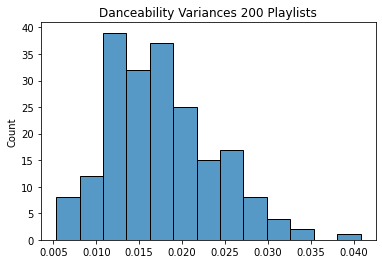

In [34]:
danceability_variances = sns.histplot(feat_vars['danceability']).set(title='Danceability Variances 200 Playlists')

### All Songs

In [30]:
summary = edafeats.describe()
summary.loc['std'] = summary.loc['std'] **2
summary

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,170089.000000,170089.000000,170089.000000,1.700890e+05,170089.000000,170089.000000,170089.000000,170089.000000,170089.000000,170089.000000,1.700890e+05,1.700890e+05,170089.000000
mean,0.569778,0.622020,5.260581,1.398356e-15,0.661783,0.087511,0.287328,0.124194,0.200912,0.472896,1.904146e-17,-4.932490e-17,3.911887
std,0.029490,0.058464,12.800083,1.000006e+00,0.223828,0.009892,0.101317,0.075581,0.030724,0.064343,1.000006e+00,1.000006e+00,0.160849
min,0.000000,0.000000,0.000000,-1.121834e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.121520e+00,-2.338930e+00,0.000000
25%,0.458000,0.459000,2.000000,-3.759491e-01,0.000000,0.034800,0.019000,0.000000,0.096000,0.265000,-7.870530e-01,-4.550188e-01,4.000000
50%,0.581000,0.660000,5.000000,2.501652e-01,1.000000,0.047300,0.141000,0.000037,0.127000,0.460000,-3.429976e-02,-1.318544e-01,4.000000
75%,0.695000,0.820000,8.000000,6.570311e-01,1.000000,0.088900,0.513000,0.020300,0.255000,0.674000,6.398950e-01,2.791778e-01,4.000000
max,0.991000,1.000000,11.000000,2.379820e+00,1.000000,0.963000,0.996000,0.999000,1.000000,1.000000,3.900397e+00,5.003347e+01,5.000000


### 200 samples of songs length 70 each

In [41]:
# Get Average playlist length
playlist_lens = []
for i in playlists:
    playlist_lens.append(len(i['tracks']))
mean_playlist_len = np.mean(playlist_lens)
mean_playlist_len

70.245

In [42]:
len(playlists)

200

In [47]:
len(edafeats)

170089

In [62]:
song_samps = []
song_samp_vars = {'danceability': [], 'energy': [], 'loudness': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [], 'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [],'key': [], 'mode': [], 'time_signature': []}

for item in range(200):
    # Sample 70 songs
    songs = edafeats.iloc[np.random.choice(170089, 70)]
    
    for i in numerical:
        var = np.var(songs[i])
        song_samp_vars[i].append(var)
        
    for i in categorical:
        highest = max(songs[i].value_counts() / songs[i].count())
        song_samp_vars[i].append(highest)
        

<Figure size 432x288 with 0 Axes>

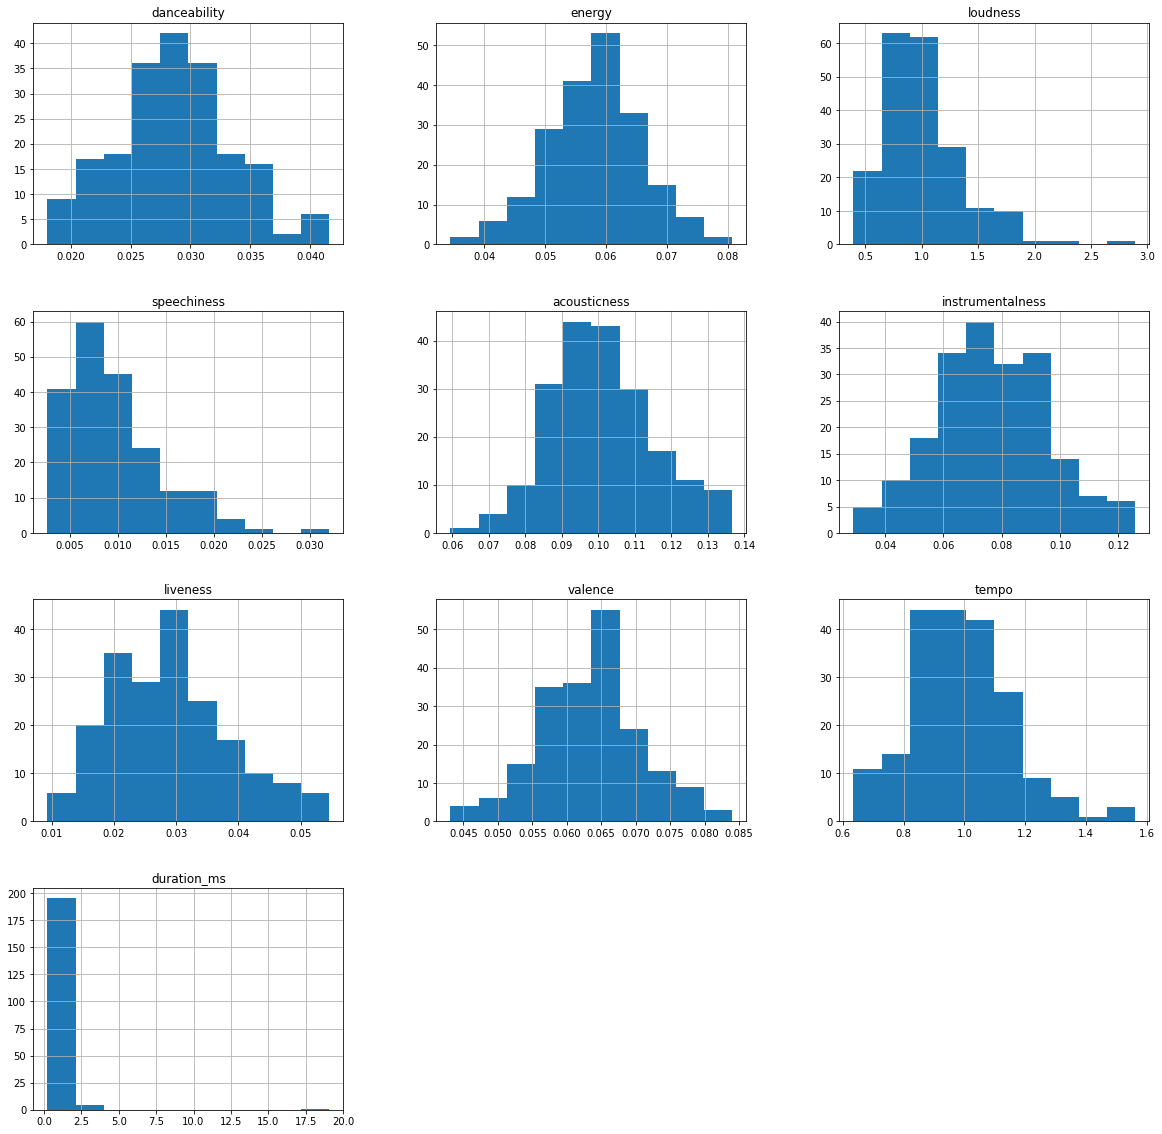

In [57]:
song_sample_vars_plot = pd.DataFrame(song_samp_vars)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

In [58]:
plt.savefig('song_sample_vars_plot.jpg')

<Figure size 432x288 with 0 Axes>

In [ ]:
# from IPython.display import Image
# Image(url= "images/no_regrets_cat.jpg", width=400, height=400)

![Cat](song_sample_vars_plot.jpg.jpg)

# Playlist Feature Plots

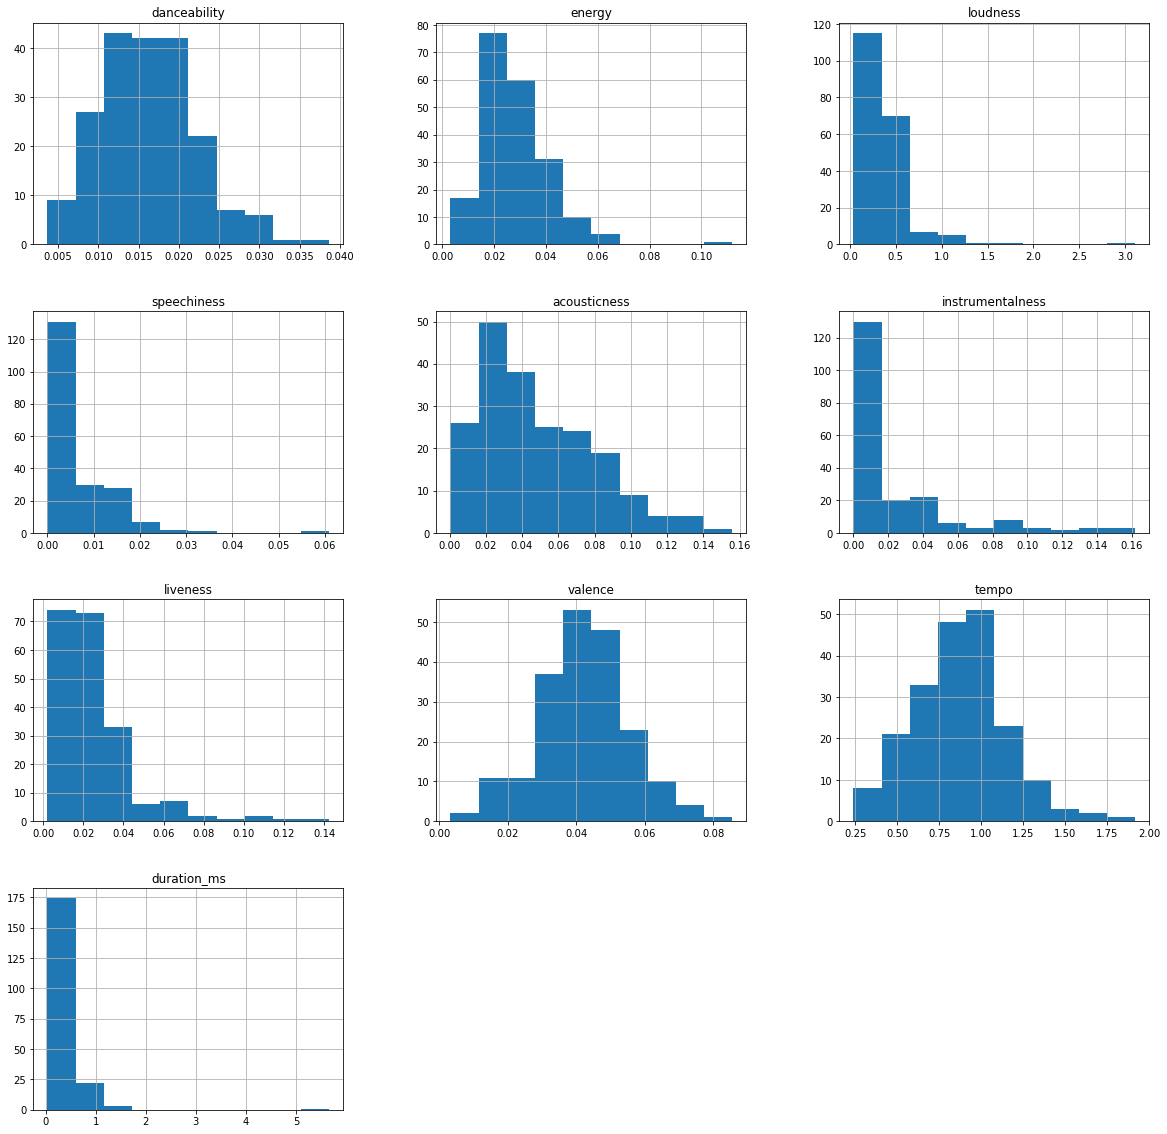

In [22]:
var_hists = pd.DataFrame(feat_vars)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

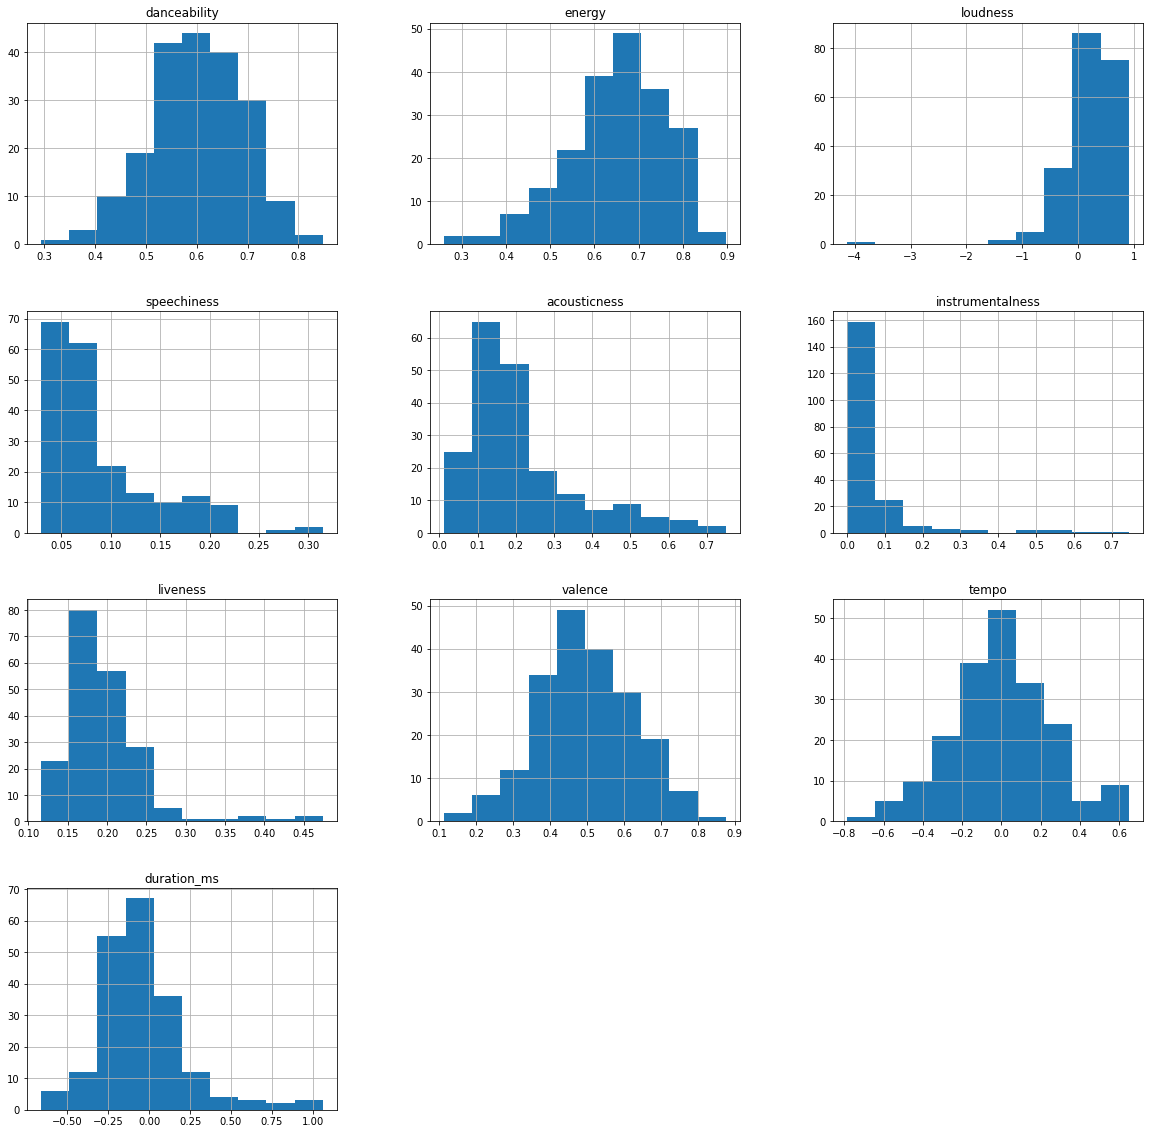

In [23]:
avg_hists = pd.DataFrame(feat_avgs)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

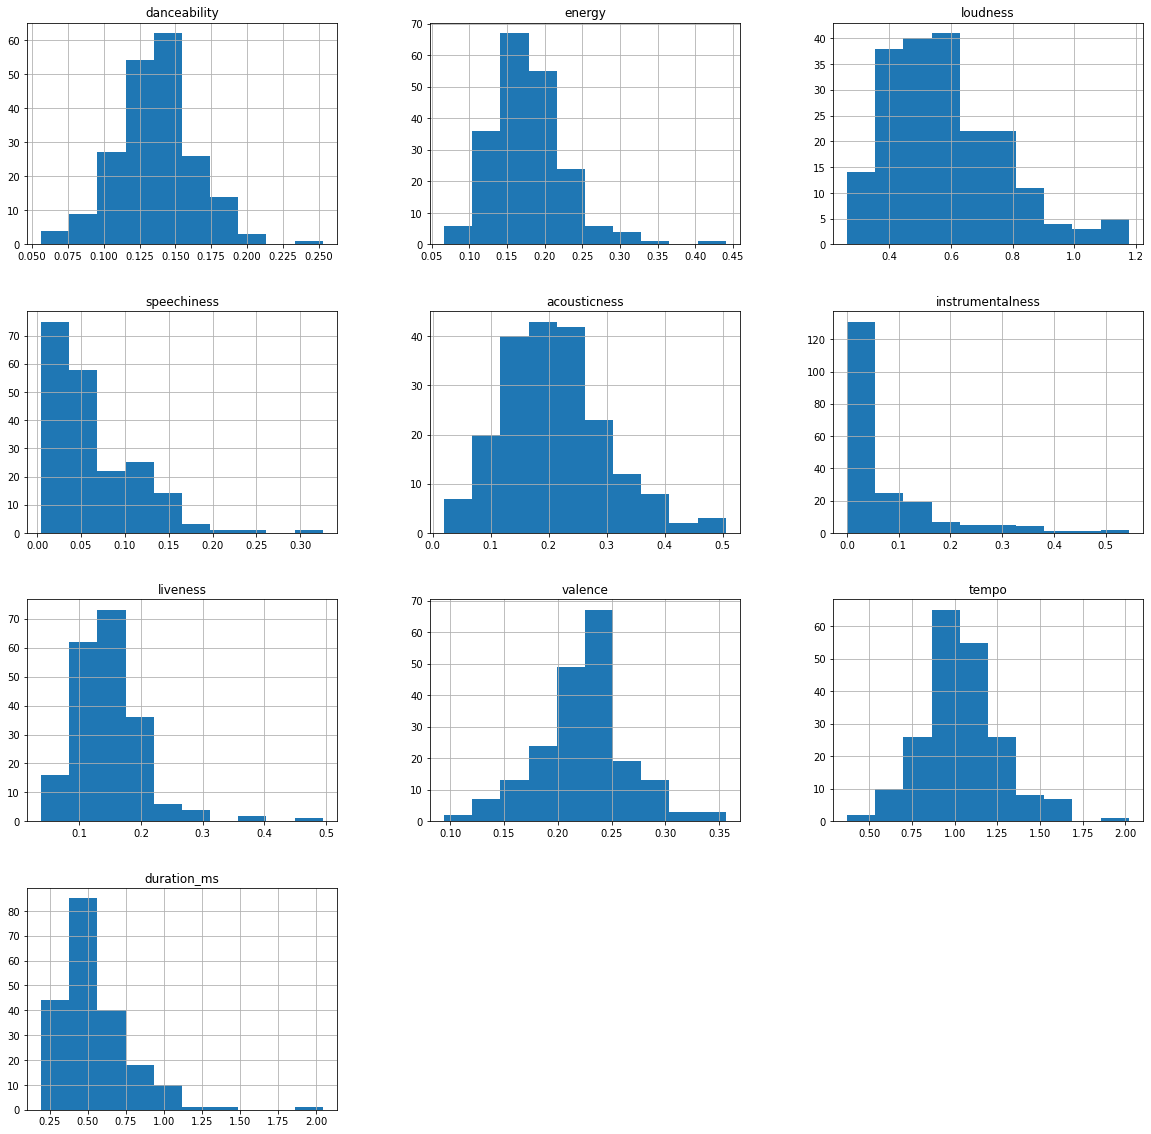

In [24]:
difs_hists = pd.DataFrame(feat_difs)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

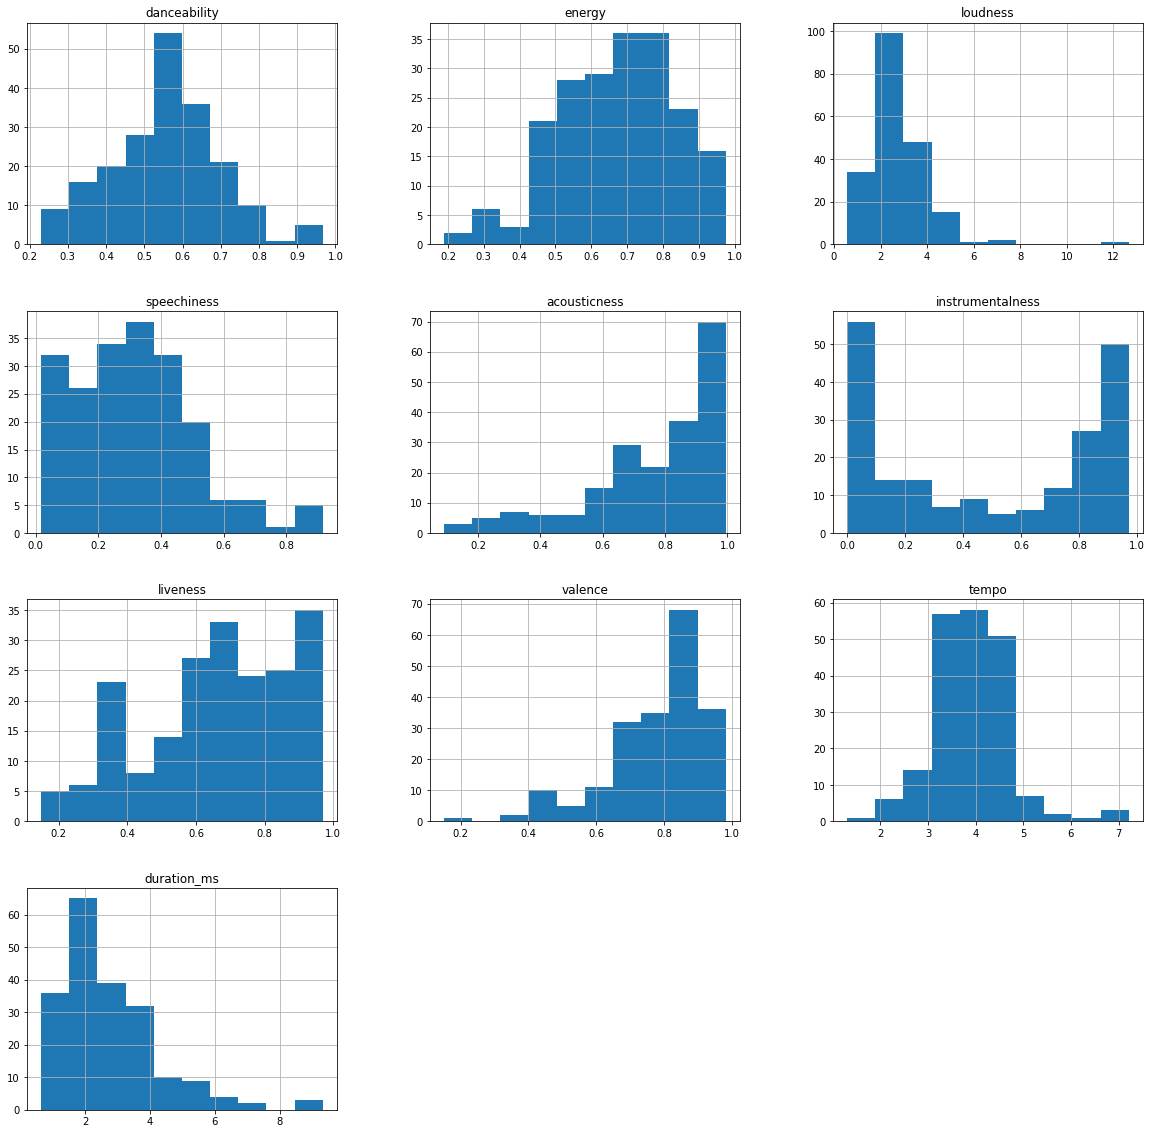

In [25]:
ranges_hists = pd.DataFrame(feat_ranges)[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].hist(figsize=(20,20))

# Overall Songs EDA

<AxesSubplot:ylabel='time_signature'>

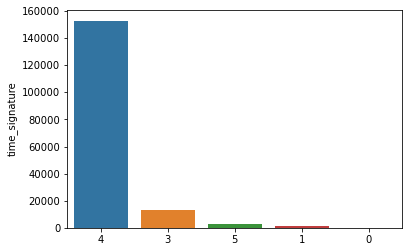

In [25]:
sns.barplot(y=edafeats['time_signature'].value_counts(), x=[str(i) for i in edafeats['time_signature'].value_counts().index])

<AxesSubplot:ylabel='key'>

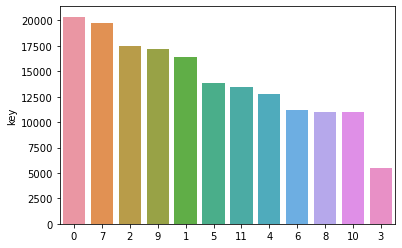

In [26]:
sns.barplot(y=edafeats['key'].value_counts(), x=[str(i) for i in edafeats['key'].value_counts().index])

<AxesSubplot:ylabel='mode'>

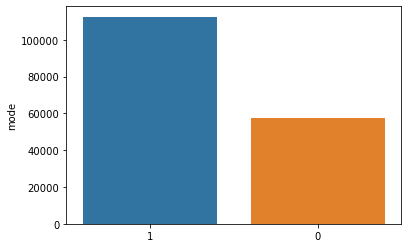

In [27]:
sns.barplot(y=edafeats['mode'].value_counts(), x=[str(i) for i in edafeats['mode'].value_counts().index])

<AxesSubplot:xlabel='energy', ylabel='Count'>

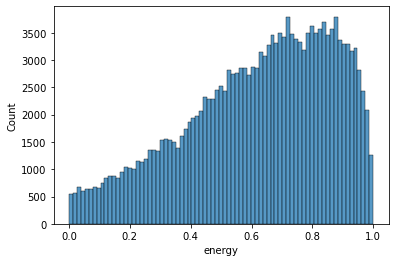

In [28]:
sns.histplot(edafeats['energy'])

<AxesSubplot:xlabel='danceability', ylabel='Count'>

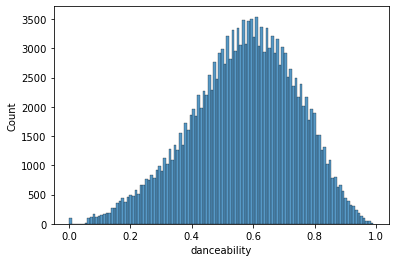

In [29]:
sns.histplot(edafeats['danceability'])

<AxesSubplot:xlabel='loudness', ylabel='Count'>

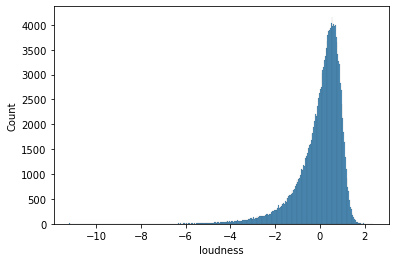

In [30]:
sns.histplot(edafeats['loudness'])

<AxesSubplot:xlabel='speechiness', ylabel='Count'>

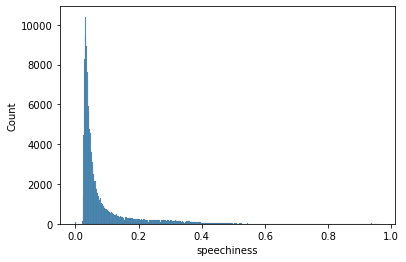

In [31]:
sns.histplot(edafeats['speechiness'])

<AxesSubplot:xlabel='acousticness', ylabel='Count'>

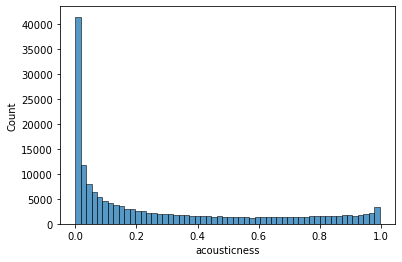

In [32]:
sns.histplot(edafeats['acousticness'])

In [33]:
sns.histplot(features['instrumentalness'])

NameError: name 'features' is not defined

In [ ]:
sns.histplot(edafeats['liveness'])

In [ ]:
sns.histplot(edafeats['valence'])

In [ ]:
sns.histplot(edafeats['tempo'])

In [ ]:
sns.histplot(edafeats['duration_ms'])